In [4]:
!pip install osmnx


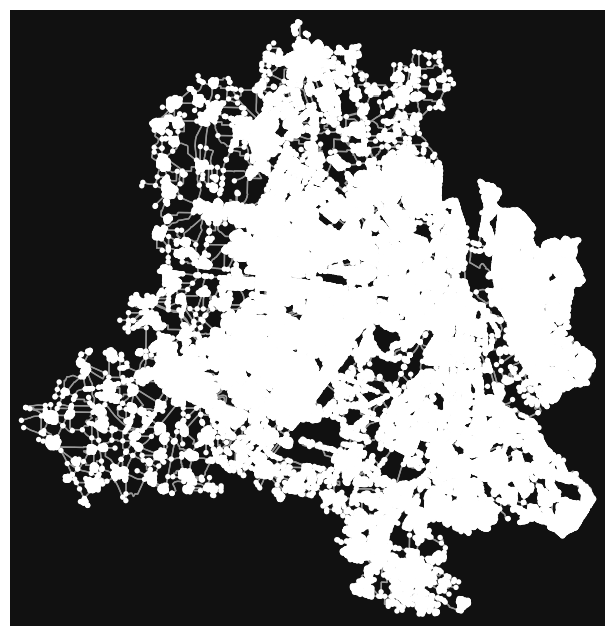

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
import osmnx as ox

# Download road network for a city
G = ox.graph_from_place('Delhi, India', network_type='drive')
ox.plot_graph(G)


In [6]:
!pip install geopandas


In [8]:
pip install pandas numpy scikit-learn osmnx networkx folium matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import os
import osmnx as ox
import networkx as nx
import folium
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [7]:
# üöÄ Traffic ML App: Least Congested Route Finder (Convert Polygons to Lines)

# üì¶ Install dependencies
!pip install geopandas pandas numpy networkx folium shapely

# üìÇ Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import folium
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon

# üìÇ Paths to datasets
road_geojson_path = r"C:\Users\sagni\Downloads\Road Traffic\archive (1)\new_delhi_traffic_dataset\geojson\new_delhi.json"
congestion_csv_path = r"C:\Users\sagni\Downloads\Road Traffic\archive (1)\new_delhi_traffic_dataset\weekday_stats\2024_week_day_congestion_city.csv"

# üì• Load road network (GeoJSON)
roads_gdf = gpd.read_file(road_geojson_path)
print("‚úÖ Road network loaded. Segments:", len(roads_gdf))

# üì• Load city-wide hourly congestion data
congestion_df = pd.read_csv(congestion_csv_path)

# üßπ Clean % strings and convert to numeric
for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    congestion_df[day] = congestion_df[day].str.rstrip('%').astype(float)

print("‚úÖ Congestion data cleaned. Shape:", congestion_df.shape)

# üìÖ User selects day and hour
day_of_week = 'Monday'   # Change as needed (Monday to Sunday)
hour_of_day = 9          # Change as needed (0-23)

# üßÆ Get congestion percentage for chosen hour & day
congestion_row = congestion_df[congestion_df['Time'] == hour_of_day]
if not congestion_row.empty:
    congestion_percent = congestion_row.iloc[0][day_of_week]
    print(f"üìä Average congestion at {hour_of_day}:00 on {day_of_week}: {congestion_percent}%")
else:
    congestion_percent = congestion_df[day_of_week].mean()
    print(f"‚ö†Ô∏è No data for {hour_of_day}:00, using mean congestion: {congestion_percent}%")

# üõ†Ô∏è Build graph from GeoJSON (convert polygons to lines)
G = nx.DiGraph()
converted = 0
for idx, row in roads_gdf.iterrows():
    geom = row['geometry']
    lines = []
    if isinstance(geom, LineString):
        lines = [geom]
    elif isinstance(geom, MultiLineString):
        lines = list(geom.geoms)
    elif isinstance(geom, Polygon):
        lines = [LineString(geom.exterior.coords)]
        converted += 1
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            lines.append(LineString(poly.exterior.coords))
        converted += 1
    else:
        continue  # skip unsupported geometries
    
    for line in lines:
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            u = coords[i]
            v = coords[i + 1]
            length_m = line.length
            base_speed_kmh = 40  # Assume average speed 40 km/h in city
            speed_kmh = base_speed_kmh * (1 - congestion_percent / 100)
            travel_time_sec = (length_m / 1000) / speed_kmh * 3600
            G.add_edge(u, v, weight=travel_time_sec, length=length_m, speed_kmh=speed_kmh)
print(f"‚úÖ Graph built. Nodes: {len(G.nodes)}, Edges: {len(G.edges)}, Polygons converted: {converted}")

# üìù Check if graph has nodes
if len(G.nodes) == 0:
    raise ValueError("‚ùå No nodes found in graph. Check GeoJSON data.")

# üìç Define start and end points (lat, lon)
origin = (28.6139, 77.2090)      # Connaught Place
destination = (28.4595, 77.0266) # Gurgaon

# üîé Find nearest nodes in graph
def get_nearest_node(G, point):
    return min(G.nodes, key=lambda n: (n[0] - point[1])**2 + (n[1] - point[0])**2)

source_node = get_nearest_node(G, origin)
target_node = get_nearest_node(G, destination)

# üõ£Ô∏è Find least congested path
route = nx.shortest_path(G, source_node, target_node, weight='weight')
print("‚úÖ Route found. Number of steps:", len(route))

# üåç Visualize route with Folium
m = folium.Map(location=origin, zoom_start=12)
route_coords = [(lat, lon) for lon, lat in route]
folium.PolyLine(route_coords, color="blue", weight=5, tooltip="Least Congested Route").add_to(m)
folium.Marker(origin, popup="Start: Connaught Place", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(destination, popup="End: Gurgaon", icon=folium.Icon(color="red")).add_to(m)

# üíæ Save and display map
output_map = "new_delhi_least_congested_route.html"
m.save(output_map)
print(f"‚úÖ Map saved as {output_map}. Open it in your browser to view the route.")


‚úÖ Road network loaded. Segments: 1
‚úÖ Congestion data cleaned. Shape: (12, 8)
‚ö†Ô∏è No data for 9:00, using mean congestion: 23.416666666666668%
‚úÖ Graph built. Nodes: 11, Edges: 11, Polygons converted: 1
‚úÖ Route found. Number of steps: 11
‚úÖ Map saved as new_delhi_least_congested_route.html. Open it in your browser to view the route.
